In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as spio
import networkx as nx

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

from eval_link_prediction import accuracy, precision, recall

from link_prediction import negative_sampling, balanced_samples

Using matplotlib backend: agg


## GraphSAGE

In [2]:
"""

GraphSAGE without Neighboring Sampling

"""

class SAGEConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels, normalize=False, bias=True):
        super(SAGEConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.linear = torch.nn.Linear(self.in_channels, out_channels, bias=False)
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_channels))
            torch.nn.init.zeros_(self.bias)
        else:
            self.register_parameter('bias', None)


    def forward(self, x, adj):
        out = torch.matmul(adj, x)
        out = out / adj.sum(dim=-1, keepdim=True).clamp(min=1)
        out = self.linear(out)

        if self.bias is not None:
            out = out + self.bias

        if self.normalize:
            out = F.normalize(out, p=2, dim=-1)

        return out

    
class Net(torch.nn.Module):
    def __init__(self, in_dim, out_dim, data):
        super(Net, self).__init__()
        self.conv1 = SAGEConv(in_dim, 16)
        self.conv2 = SAGEConv(16, out_dim)
        
        # predict exists or not
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2 * out_dim, 50),
            torch.nn.ELU(),
            torch.nn.Linear(50, 1),
            torch.nn.Sigmoid()
        )
        
        # link injection initialized
        injection = torch.ones_like(data.adj) * 0.01
        injection = torch.abs(injection)
        self.injection = torch.nn.Parameter(
            injection, 
            requires_grad=True
        )

    def forward(self, data, query_index):
        x, adj = data.x, data.adj
        
        # link injection
        injection = F.relu(self.injection)
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
        
        # generate node embeddings
        emb = self.conv1(x, adj)
        emb = F.relu(emb)
        emb = F.dropout(emb, p=0.5, training=self.training)
        emb = self.conv2(emb, adj)
        
        # get queried embeddings
        emb_query = torch.cat((emb[query_index[0]], emb[query_index[1]]), dim=1)
        
        # using embeddings to get score out
        score = self.layers(emb_query)
        
        return score
    
    def get_weight(self, data, query_index):
        adj = data.adj.detach()
        
        # link injection
        injection = F.relu(self.injection.detach())
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
        
        # weight
        weights = adj[query_index[0], query_index[1]].view(-1, 1)
        return weights

## Split Dataset

In [3]:
# set device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# load data
name = 'Cora'
dataset = Planetoid('../datasets/'+ name, name=name)
data = dataset.data

# random sampling edges
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

# split edges
edges = data.edge_index.detach().cpu().numpy().T
edge_train, edge_test = train_test_split(edges, train_size=train_frac, random_state=42)
edge_val, edge_test = train_test_split(
    edge_test, 
    train_size=val_frac/(test_frac + val_frac), 
    random_state=42
)

# create train, validation, test positive edges
data.edge_train = torch.Tensor(edge_train).long().t()
data.edge_val = torch.Tensor(edge_val).long().t()
data.edge_test = torch.Tensor(edge_test).long().t()
data.y_train = torch.ones(len(edge_train), 1).long().t()
data.y_val = torch.ones(len(edge_val), 1).long().t()
data.y_test = torch.ones(len(edge_test), 1).long().t()

# create adjacency matrix
data.adj = to_dense_adj(add_self_loops(data.edge_train)[0])[0]

# to device (GPU default)
data = dataset.data.to(device)

# record the 
num_nodes = data.x.shape[0]
num_edges = data.edge_index.shape[1]
num_train = len(data.edge_train.t())
num_val = len(data.edge_val.t())
num_test = len(data.edge_test.t())

print('Number of nodes =', num_nodes)
print('Number of edges =', num_edges)
print('Training edges =', num_train)
print('Validation edges =', num_val)
print('Test edges =', num_test)

Number of nodes = 2708
Number of edges = 10556
Training edges = 8444
Validation edges = 1056
Test edges = 1056


## Compile Model

In [4]:
from tqdm import tqdm

NUMEPOCHS = 30000
early_stop_win_size = 100
tolerance = 1.00

# compile model
in_dim = data.x.shape[1]

model = Net(
    in_dim,
    50,
    data
).to(device)

optimizer = torch.optim.Adamax(model.parameters(), weight_decay=1e-4)

criterion = torch.nn.modules.loss.BCELoss()

# Training

In [5]:
# get the initial injection
injection_init = model.injection.detach().cpu().numpy()

In [6]:
# record accuracy
train_loss = np.zeros(NUMEPOCHS)
val_loss = np.zeros(NUMEPOCHS)
test_loss = np.zeros(NUMEPOCHS)

# tracking injection
injection_sum = np.zeros(NUMEPOCHS)

# negative sampling
edge_test, y_test = balanced_samples(data.edge_test, num_nodes)
y_test_injected = model.get_weight(data, edge_test)

# training start
for epoch in range(NUMEPOCHS):
    # negative sampling
    edge_train, y_train = balanced_samples(data.edge_train, num_nodes)
    edge_val, y_val = balanced_samples(data.edge_val, num_nodes)
    
    # consistent with prediction
    y_train = model.get_weight(data, edge_train)
    
    model.train()
    optimizer.zero_grad()
    out = model(data, edge_train)
    loss = criterion(out, y_train.float())
    loss.backward()
    optimizer.step()
    
    # record the loss
    train_loss[epoch] = loss.item()
    model.eval()
    val_loss[epoch] = criterion(model(data, edge_val), y_val.float()).item()
    test_loss[epoch] = criterion(model(data, edge_test), y_test.float()).item()
    
    # get the injection
    injection = F.relu(model.injection.detach()).cpu().numpy()
    injection_sum[epoch] = np.sum(injection)

    if epoch % 500 == 0:
        print(
            epoch, 
            ', train loss =', loss.item(),
            ', val loss =', val_loss[epoch], 
        )

0 , train loss = 0.6931598782539368 , val loss = 0.6932029724121094
500 , train loss = 0.5344206690788269 , val loss = 0.6522175669670105
1000 , train loss = 0.5151882767677307 , val loss = 0.6744700074195862
1500 , train loss = 0.4186982214450836 , val loss = 0.8156817555427551
2000 , train loss = 0.33507758378982544 , val loss = 0.8547941446304321
2500 , train loss = 0.2860386073589325 , val loss = 0.9230919480323792
3000 , train loss = 0.2681230902671814 , val loss = 0.9923494458198547
3500 , train loss = 0.27291378378868103 , val loss = 1.0156619548797607
4000 , train loss = 0.23717224597930908 , val loss = 1.0591826438903809
4500 , train loss = 0.22937753796577454 , val loss = 1.0599242448806763
5000 , train loss = 0.2086530327796936 , val loss = 1.0745768547058105
5500 , train loss = 0.2185036987066269 , val loss = 1.1416006088256836
6000 , train loss = 0.19853830337524414 , val loss = 1.1112240552902222
6500 , train loss = 0.19646669924259186 , val loss = 1.0857295989990234
7000

In [7]:
# get the initial injection
injection_final = F.relu(model.injection.detach()).cpu().numpy()

In [8]:
print('Initial injection = \n', injection_init)
print('\nSum inital = %d\n' % np.sum(injection_init))
print('Final injection = \n', injection_final)
print('\nSum final = %d\n' % np.sum(injection_final))

Initial injection = 
 [[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]

Sum inital = 73333

Final injection = 
 [[3.4331506e-06 6.6448725e-03 0.0000000e+00 ... 2.4269152e-02
  8.0013191e-03 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 2.2566151e-03 ... 0.0000000e+00
  9.3618399e-03 0.0000000e+00]
 [0.0000000e+00 6.1976811e-05 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  6.4644269e-03 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 3.1382997e-02
  7.6888606e-04 2.2911239e-05]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.7304193e-02
  0.0000000e+00 0.0000000e+00]]

Sum final = 17102



In [27]:
np.save('../variables/injection_sum_sage', injection_sum)
np.save('../variables/injection_final_sage', injection_final)
np.save('../variables/injection_init_sage', injection_init)

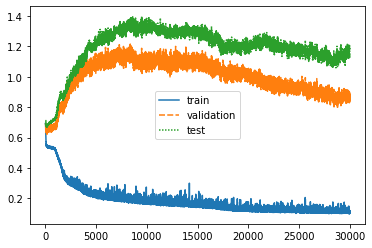

In [9]:
df_acc = pd.DataFrame({
    'train': train_loss,
    'validation': val_loss,
    'test': test_loss
})

sns.lineplot(data=df_acc)
plt.show()

In [10]:
edge_train, y_train = balanced_samples(data.edge_train, num_nodes)
edge_val, y_val = balanced_samples(data.edge_val, num_nodes)
edge_test, y_test = balanced_samples(data.edge_test, num_nodes)

train_score = model(data, edge_train).detach().cpu().numpy().ravel()
val_score = model(data, edge_val).detach().cpu().numpy().ravel()
test_score = model(data, edge_test).detach().cpu().numpy().ravel()

train_pred = (train_score > 0.5).astype(np.int8)
val_pred = (val_score > 0.5).astype(np.int8)
test_pred = (test_score > 0.5).astype(np.int8)

print('Train Accuracy: {:.4f}'.format(accuracy(train_pred, y_train)))
print('Validation Accuracy: {:.4f}'.format(accuracy(val_pred, y_val)))
print('Test Accuracy: {:.4f}'.format(accuracy(test_pred, y_test)))

print('Train Precision: {:.4f}'.format(precision(train_pred, y_train)))
print('Validation Precision: {:.4f}'.format(precision(val_pred, y_val)))
print('Test Precision: {:.4f}'.format(precision(test_pred, y_test)))

print('Train Recall: {:.4f}'.format(recall(train_pred, y_train)))
print('Validation Recall: {:.4f}'.format(recall(val_pred, y_val)))
print('Test Recall: {:.4f}'.format(recall(test_pred, y_test)))

Train Accuracy: 0.9787
Validation Accuracy: 0.9228
Test Accuracy: 0.9242
Train Precision: 0.9593
Validation Precision: 0.9570
Test Precision: 0.9553
Train Recall: 0.9998
Validation Recall: 0.8854
Test Recall: 0.8902


In [11]:
test_acc_all = np.array([0.9328, 0.9247, 0.9332, 0.9356, 0.9380])
test_precision_all = np.array([0.9644, 0.9427, 0.9654, 0.9684, 0.9753])
test_recall_all = np.array([0.8987, 0.9044, 0.8987, 0.9006, 0.8987])

print(np.mean(test_acc_all))
print(np.mean(test_precision_all))
print(np.mean(test_recall_all))

print(np.std(test_acc_all))
print(np.std(test_precision_all))
print(np.mean(test_recall_all))

0.93286
0.9632400000000001
0.90022
0.004486245646417502
0.010954195543261038
0.90022


In [12]:
# for latex
print('$%.2f\pm%.2f$' % (np.mean(test_acc_all) * 100, np.std(test_acc_all) * 100))
print('$%.2f\pm%.2f$' % (np.mean(test_precision_all) * 100, np.std(test_precision_all) * 100))
print('$%.2f\pm%.2f$' % (np.mean(test_recall_all) * 100, np.std(test_recall_all) * 100))

$93.29\pm0.45$
$96.32\pm1.10$
$90.02\pm0.22$


[[1208  187]
 [2666 2665]
 [1059 1600]
 ...
 [2565 2255]
 [ 968  475]
 [ 333 1161]]
[0.75991875 0.6947593  0.629517   ... 0.0615881  0.06158794 0.06158615]
(10556, 2)
(10556,)


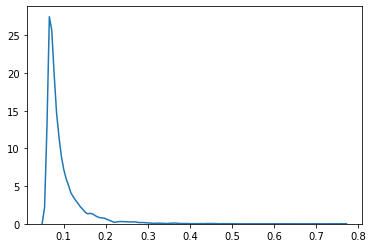

In [13]:
# get non-zero injected links
indexes = injection_final.nonzero()
index_arr = np.stack(indexes)
values = injection_final[indexes]

# sort injected links
sorted_idx = np.flip(np.argsort(values))

sorted_index = index_arr[:, sorted_idx]
sorted_values = values[sorted_idx]

# get the largest N out
num_edges = data.edge_index.size(1)
pred_index = sorted_index[:, :num_edges].T
pred_values = sorted_values[:num_edges]
print(pred_index)
print(pred_values)
print(pred_index.shape)
print(pred_values.shape)

sns.distplot(pred_values, hist=False)
plt.show()

In [14]:
if False:
    np.save('../variables/sorted_SAGE_injection', sorted_index)
    np.save('../variables/sorted_SAGE_weights', sorted_values)

In [15]:
# get the highest score out
print(pred_index[:10])
print(pred_values[:10])

[[1208  187]
 [2666 2665]
 [1059 1600]
 [ 278 2622]
 [1853 2622]
 [ 560  585]
 [ 947 2622]
 [ 555 2622]
 [ 278  991]
 [ 555  991]]
[0.75991875 0.6947593  0.629517   0.50076467 0.49579364 0.4817468
 0.4757535  0.47420868 0.46106422 0.4605792 ]


In [16]:
def show_ego_graph(data, index):
    # convert to graph
    G = torch_geometric.utils.to_networkx(
        dataset.data, node_attrs=None, edge_attrs=None
    )

    # Create ego graph of main hub
    hub_ego = nx.ego_graph(G, index, radius=2)

    # Draw graph
    pos = nx.spring_layout(hub_ego)
    nx.draw(hub_ego, pos, node_color='b', node_size=50, with_labels=False)

    # Draw ego as large and red
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[index], node_size=100, node_color='r')
    plt.show()

def show_link_graph(data, src, dst, numbering=None):
    # convert to graph
    G = torch_geometric.utils.to_networkx(
        dataset.data, node_attrs=None, edge_attrs=None
    )

    # Create ego graph of main hub
    src_ego = nx.ego_graph(G, src, radius=2)
    dst_ego = nx.ego_graph(G, dst, radius=2)
    
    hub_ego = nx.algorithms.operators.binary.compose(src_ego, dst_ego)
    
    f = plt.figure(figsize=(8, 6))
    
    # Draw graph
    pos = nx.spring_layout(hub_ego)
    nx.draw(hub_ego, pos, node_color='b', node_size=50, with_labels=False, alpha=0.2)
    
    # Draw ego as large and red
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[src, dst], node_size=100, node_color='r', alpha=0.8)
    if numbering is None:
        f.savefig("link_graph.pdf", bbox_inches='tight')
    else:
        f.savefig("link_graph_%d.pdf" % numbering, bbox_inches='tight')
    plt.show()

/home/jayroxis/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/jayroxis/venv/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


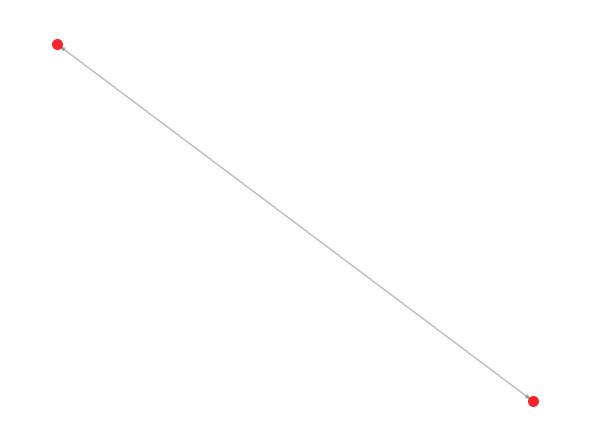

In [17]:
show_link_graph(data, pred_index[0][0], pred_index[0][1])

### Top 50 Shortest Path

In [18]:
G = torch_geometric.utils.to_networkx(
        dataset.data, node_attrs=None, edge_attrs=None
    )

for src, dst in pred_index[:50]:
    if nx.has_path(G, source=src, target=dst):
        shortest_path = nx.shortest_path(G, source=src, target=src)
        print(src, dst, shortest_path, len(shortest_path))
    else:
        print(src, dst, nx.has_path(G, source=src, target=dst))

1208 187 [1208] 1
2666 2665 [2666] 1
1059 1600 [1059] 1
278 2622 False
1853 2622 False
560 585 [560] 1
947 2622 False
555 2622 False
278 991 False
555 991 False
1853 991 False
475 2622 False
2589 2622 False
1700 2622 False
1612 2622 False
63 2622 False
774 2526 [774] 1
947 991 False
475 991 False
1612 991 False
63 991 False
2589 991 False
1125 2622 False
1811 2622 False
1700 991 False
1358 2158 False
1125 991 False
241 1701 [241] 1
2273 1701 [2273] 1
50 1701 [50] 1
947 1698 False
1161 2622 False
635 2622 False
1811 991 False
2696 2622 False
1707 1701 [1707] 1
224 1701 [224] 1
648 1701 [648] 1
1060 1701 [1060] 1
2271 1701 [2271] 1
212 2622 False
786 2622 False
1238 1701 [1238] 1
1875 1701 [1875] 1
882 1701 [882] 1
635 991 False
501 1701 [501] 1
1358 769 [1358] 1
2696 991 False
1161 991 False


### Top Injected Links (Predicted Use Link Injection)

In [19]:
path_length = []
src_list, dst_list = [], []

for src, dst in pred_index:
    src_list.append(src)
    dst_list.append(dst)
    if nx.has_path(G, source=src, target=dst):
        shortest_path = nx.shortest_path(G, source=src, target=src)
        path_length.append(len(shortest_path))
    else:
        path_length.append(0)
        
path_length = np.array(path_length)

In [20]:
num_pred = pred_index.shape[0]

direct_link = np.sum(path_length == 1) / num_pred # directed connected,i.e., neighbors
indirect_link = np.sum(path_length > 1)/ num_pred # have a path between but not neighbors
unconnected = np.sum(path_length == 0) / num_pred # directed connected,i.e., neighbors
unconnected_pos = np.where(path_length == 0)[0]

print(direct_link)
print(indirect_link)
print(unconnected)
print(np.mean(unconnected_pos))

0.6987495263357333
0.0
0.30125047366426677
5157.391823899371


In [21]:
0.7295377036756348 * 10556

7701.0

3 [ 278 2622]
tensor(3, device='cuda:1') tensor(6, device='cuda:1')


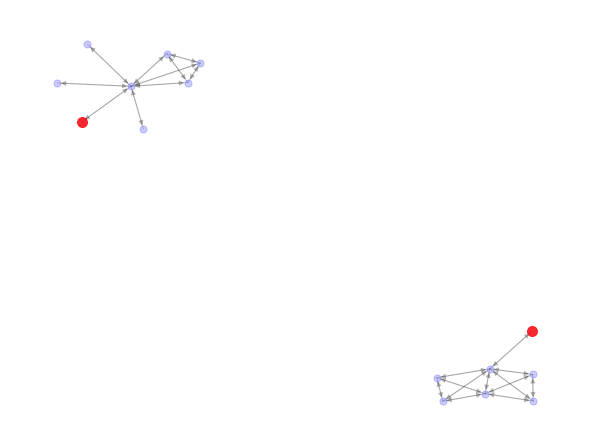

4 [1853 2622]
tensor(3, device='cuda:1') tensor(6, device='cuda:1')


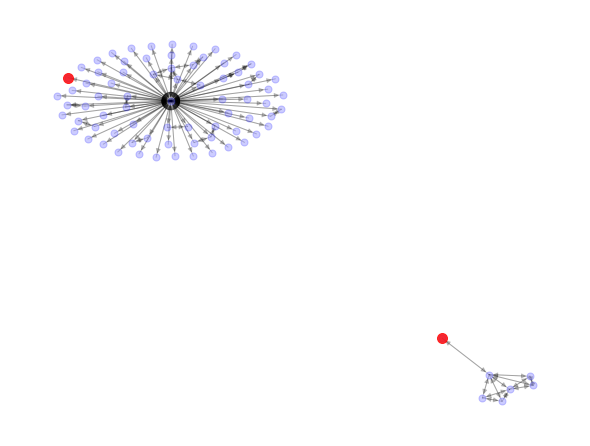

6 [ 947 2622]
tensor(4, device='cuda:1') tensor(6, device='cuda:1')


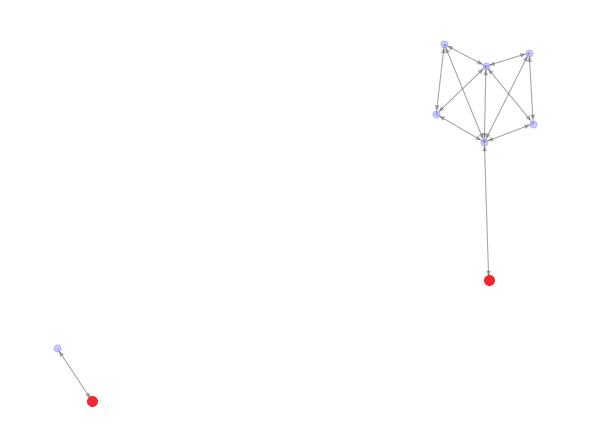

7 [ 555 2622]
tensor(3, device='cuda:1') tensor(6, device='cuda:1')


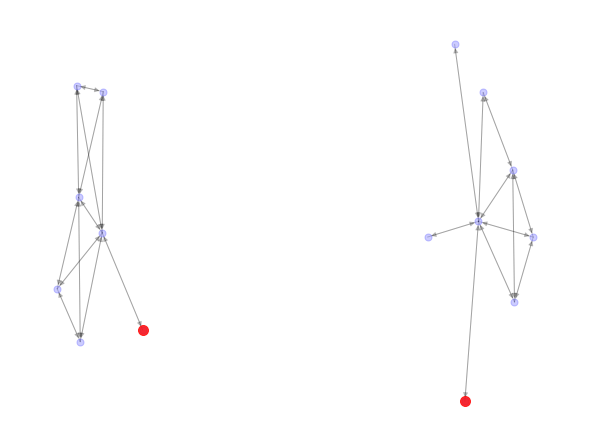

8 [278 991]
tensor(3, device='cuda:1') tensor(6, device='cuda:1')


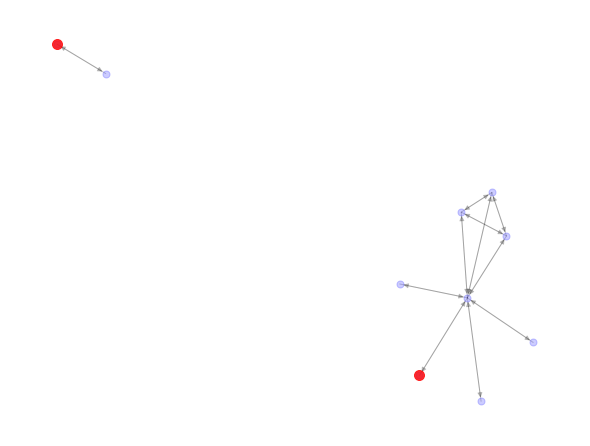

In [22]:
for i in range(5):
    idx = unconnected_pos[i]
    print(idx, pred_index[idx])
    src = pred_index[idx][0]
    dst = pred_index[idx][1]
    print(data.y[src], data.y[dst])
    show_link_graph(data, src, dst, numbering=i+1)

### Link Injected (Not In Training Set) Found in Orginal Graph

In [23]:
# find out how many injected links are in the graph
true_index = data.edge_index.cpu().numpy().T

start = true_index[:, 0]

unq_val, unq_idx = np.unique(start, return_index=True)
start_dict = dict(zip(unq_val, unq_idx))

correct_list = []
for i in range(len(pred_index)):
    pred = pred_index[i]
    if pred[0] in start_dict:
        begin = start_dict[pred[0]]
        if pred[0] + 1 in start_dict:
            end = start_dict[pred[0] + 1]
        else:
            end = len(true_index)
    for j in range(begin, end):
        true = true_index[j]
        if np.array_equal(pred, true):
            print(i, j, pred, true)
            correct_list.append((i, pred))
            break

0 4715 [1208  187] [1208  187]
1 10449 [2666 2665] [2666 2665]
2 4113 [1059 1600] [1059 1600]
43 7618 [1875 1701] [1875 1701]
101 4829 [1238 1358] [1238 1358]
106 906 [ 215 1701] [ 215 1701]
125 5918 [1492 1358] [1492 1358]
128 7077 [1752 1358] [1752 1358]
172 10276 [2569  380] [2569  380]
179 4722 [1212 1701] [1212 1701]
182 1568 [ 385 2484] [ 385 2484]
213 6850 [1709 1358] [1709 1358]
306 3312 [ 832 2600] [ 832 2600]
345 8142 [1986  335] [1986  335]
359 856 [ 198 1255] [ 198 1255]
426 5297 [1358  686] [1358  686]
455 533 [ 117 2537] [ 117 2537]
466 88 [26 99] [26 99]
516 5418 [1358 1760] [1358 1760]
551 5331 [1358 1123] [1358 1123]
570 5851 [1476 1170] [1476 1170]
637 1566 [385 369] [385 369]
642 5259 [1358   34] [1358   34]
686 5850 [1476  404] [1476  404]
888 4588 [1171 1855] [1171 1855]
1041 5712 [1439  200] [1439  200]
1072 6105 [1542  216] [1542  216]
1194 532 [117 259] [117 259]
1371 6281 [1589  101] [1589  101]
1381 6762 [1701 1100] [1701 1100]
1521 1160 [ 287 2705] [ 287 2705

In [24]:
hit_rate = len(correct_list) / num_edges
print('hits =', len(correct_list))
print('hit rate =', hit_rate)
print('number of top-scored predictions =', len(pred_index))
print('number of edges in the graph =', len(true_index))
num_options = len(true_index) ** 2
print('p =', 1 / num_options)
print('significance =', hit_rate * num_options)

hits = 83
hit rate = 0.00786282682834407
number of top-scored predictions = 10556
number of edges in the graph = 10556
p = 8.974313504503885e-09
significance = 876148.0000000001


In [25]:
print('%.3f\\%%' % (0.009568018188707844 * 5 * 100))

4.784\%


In [26]:
MR = np.mean(np.array([item[0] for item in correct_list]))
print('MR =', MR)
print('MR Ratio =', 1 - MR / num_edges)

MR = 3703.012048192771
MR Ratio = 0.6492031026721512
